In [1]:
### 02/15/2023 updated
### this python script compares the power spectrum of the perturbed and unperturbed beams;
### takes the difference in theta space (sky), and then FFT to ell space;
### generates a plot of leakage level as a function of error amplitude for a fixed k_in and k_out and before noise normalization

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.stats import binned_statistic
import scipy.optimize as opt
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
plt.rcParams['font.size'] = 13
%run Fraunhofer
%run ErrMask

In [2]:
# measure sigma in angle (rad)
def gaussian(x, A, sigma, x0): 
    g = A*np.exp(-(x-x0)**2/(2*sigma**2))
    return(g)

def analytical(l, sigma): # blm
    fft = bin_mean0.max()* np.exp(-l*(l+1)*sigma**2/2)
    return(fft)

In [13]:
N_screen = 2048
N_theta = 512
D = 10.0
sigma = 1.0
maxdeg = 5.0
trunc = 'y'
option = 'amp'
leak = []
#amp = [1.0, 5.0, 10.0, 30.0, 50.0, 100.0]
amp = [5.0]

# perfect gaussian create E screen [m]
screen = {}
screen['N'] = N_screen
screen['D'] = D
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, sigma)
if trunc=='y':
    InCircle(screen, center, 2.0)
ScreenFFT(screen)

# interpolation in sky intensity [rad] (unperturbed beam)
lam = 0.002 #mm wavelength
thetamaxdeg = maxdeg
thetamax = thetamaxdeg*np.pi/180. # in radians
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam)   # unperturbed
fft_I0 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))) # in ell space
theta_vec = np.linspace(0,2*thetamax,N_theta) #rad
print('theta max = ', (1/lam)*np.sin(screen['kap'].max()))

#calculate ell
n = theta_vec.shape[0]
dl = 2*np.pi/theta_vec.max() # dl in 1/rad space
l_vec = np.fft.fftshift(dl * np.fft.fftfreq(n)*n)
(l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
l = np.sqrt(l_x**2 + l_y**2)

for i in range(len(amp)):
    print('amp =', amp[i])
    # input parameters
#     N_screen = 4096
#     N_theta = 1024
#     D = 10.0
#     sigma = 1.0
#     maxdeg = 3.0
#     trunc = 'y'
#     option = 'amp'
    #amp = 3.0
    
    # perturbed E screen
    screen1 = {}
    screen1['N'] = N_screen
    screen1['D'] = D
    Initialize(screen1)
    MultByGaussian(screen1, center, sigma)
    if trunc=='y':
        InCircle(screen1, center, 2.0)
    
    if option=='phase':
        filter_annulus_phase(screen1, amp[i], 10, 12)
    elif option=='amp':
        filter_annulus_amp(screen1, amp[i], 10, 12)
    else: print('Choose phase or amplitude errors')
    
    ScreenFFT(screen1)
    
    # interpolate the perturbed beam 
    theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
    II1 = Project_I_on_thetagrid(theta_vec, screen1, lam) # perturbed
    # shift the beam from being centered at theta=0 to theta=thetamax so that the beam spans from 0 deg to 2*thetamax deg
    theta_vec = np.linspace(0,2*thetamax,N_theta) #rad
    
    # FT of sky intensity
    I_diff = II1 - II0 # take the difference in theta space (sky)
    fft_Idiff = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I_diff)))) # FFT the difference to ell space
    fft_I1 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II1)))) # in ell space
    
    # average (FT of II0)^2 radially 
    bin_edges = np.linspace(0,l.max(),int(len(theta_vec)/2))
    l_flatten = l.flatten()
    fft_numerical0 = fft_I0.flatten()
    fft_numerical1 = fft_I1.flatten()
    fft_numerical_diff = fft_Idiff.flatten()
    bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical0, statistic='mean', bins=bin_edges) 
    bin_mean1, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical1, statistic='mean', bins=bin_edges) # bin_mean is the binned numerical beam
    bin_mean_diff, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical_diff, statistic='mean', bins=bin_edges) # bin the beam difference
    l_vec = bin_edges[0:-1] # ell 1D vector
    
    beam_diff_rela = bin_mean_diff/bin_mean0 # relative beam difference
    print(l_vec[1:3]) # making sure we average the leakage at ell=85 and ell=170
    leak.append(np.mean(beam_diff_rela[1:3])) # average the beam difference at l=85 and l=170 (2nd and 3rd elements)
    print('Error amplitude is {}, the corresponding leakage^2 is {:.5f}'.format(amp[i], leak[i]**2))
print(dl)

amp = 5.0
[ 85.01886622 170.03773243]
Error amplitude is 5.0, the corresponding leakage^2 is 0.00024
60.0


In [12]:
print('Error amplitude is {}, the corresponding leakage^2 is {:.3e}'.format(amp[1], leak[1]**2))

Error amplitude is 5.0, the corresponding leakage^2 is 1.696e-05


[ 3.16241118e-05 -6.07914115e-04  5.74721651e-03]


Text(0.5, 1.0, 'residual')

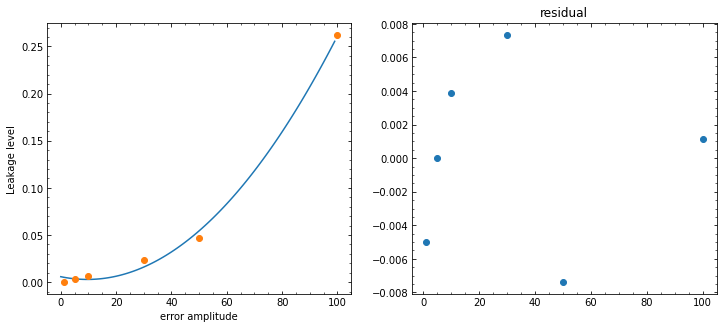

In [6]:
def quad(x, a,b,c):
    return(a*x**2+b*x+c)
(fit,err) = opt.curve_fit(quad, amp, leak, absolute_sigma=True)
x = np.arange(100)
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x, quad(x, fit[0], fit[1], fit[2]))
plt.plot(amp,leak,'o')
plt.xlabel('error amplitude')
plt.ylabel('Leakage level')
print(fit)
plt.subplot(1,2,2)
plt.plot(amp, leak - quad(np.array(amp), fit[0], fit[1], fit[2]), 'o')
plt.title('residual')

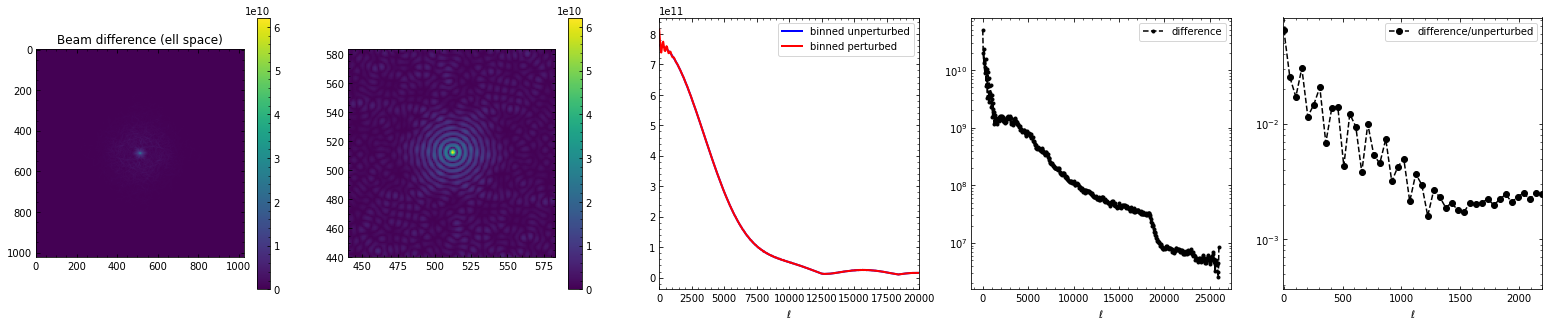

In [11]:

# plot the difference
fig = plt.figure(figsize=(27,5))
plt.subplot(1,5,1) # plot the beam difference fft_Idiff - take the difference in theta space, then FFT
plt.imshow(fft_Idiff, interpolation=None) 
plt.colorbar()
plt.title('Beam difference (ell space)')
plt.subplot(1,5,2) # plot the beam difference fft_Idiff and zoom in at the center 
plt.imshow(fft_Idiff, interpolation=None) 
plt.colorbar()
plt.xlim(int(N_theta*0.43),int(N_theta*0.57))
plt.ylim(int(N_theta*0.43),int(N_theta*0.57))
plt.subplot(1,5,3) # plot the power spectrum of the numerical and analytical beam in ell space respectively, and compare to the theory
plt.plot(l_vec,bin_mean0,color='blue', lw=2, label='binned unperturbed') 
plt.plot(l_vec,bin_mean1,color='red', lw=2, label='binned perturbed')
plt.xlabel(r'$\ell$')
#plt.plot(bin_edges, analytical(bin_edges, fit[1]), color='black', lw=3, ls=':', label='analytical blm')
plt.xlim(0,2e4)
plt.legend()
plt.subplot(1,5,4) # plot the power spectrum of the beam difference in log scale - take the difference and then FFT
plt.semilogy(l_vec,bin_mean_diff, 'o--', ms=3, color='black', label='difference') 
plt.xlabel(r'$\ell$')
plt.legend()
#plt.xlim(-10,2e4)
plt.subplot(1,5,5) # # plot the power spectrum of the relative beam difference in log scale by dividing the beam difference by the numerical unperturbed beam
plt.semilogy(l_vec,bin_mean_diff/bin_mean0,'o--', color='black', label='difference/unperturbed') 
plt.xlabel(r'$\ell$')
plt.legend()
plt.xlim(-10,2200)
plt.legend()
plt.show()

# 03/08 
shifts the annulus filter, fixing the radius.

In [32]:
N_screen = 2048
N_theta = 512
D = 10.0
sigma = 1.0
maxdeg = 2.0
trunc = 'y'
option = 'amp'
leak = np.zeros((len(k_in),len(amp)))
k_in = [10, 50]
amp = [1.0, 10.0, 50.0]

# perfect gaussian create E screen [m]
screen = {}
screen['N'] = N_screen
screen['D'] = D
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, sigma)
if trunc=='y':
    InCircle(screen, center, 2.0)
ScreenFFT(screen)

# interpolation in sky intensity [rad] (unperturbed beam)
lam = 0.002 #mm wavelength
thetamaxdeg = maxdeg
thetamax = thetamaxdeg*np.pi/180. # in radians
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam)   # unperturbed
fft_I0 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))) # in ell space
theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

#calculate ell
n = theta_vec.shape[0]
dl = 2*np.pi/theta_vec.max() # dl in 1/rad space
l_vec = np.fft.fftshift(dl * np.fft.fftfreq(n)*n)
(l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
l = np.sqrt(l_x**2 + l_y**2)

for j in range(len(k_in)):
    kin = k_in[j]
    kout = kin + 2
    
    for i in range(len(amp)):
        print('amp =', amp[i], 'k_in =', kin, 'k_out =', kout)
    
        # perturbed E screen
        screen1 = {}
        screen1['N'] = N_screen
        screen1['D'] = D
        Initialize(screen1)
        MultByGaussian(screen1, center, sigma)
        if trunc=='y':
            InCircle(screen1, center, 2.0)

        if option=='phase':
            filter_annulus_phase(screen1, amp[i], kin, kout)
        elif option=='amp':
            filter_annulus_amp(screen1, amp[i], kin, kout)
        else: print('Choose phase or amplitude errors')

        ScreenFFT(screen1)

        # interpolate the perturbed beam 
        theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
        II1 = Project_I_on_thetagrid(theta_vec, screen1, lam) # perturbed
        # shift the beam from being centered at theta=0 to theta=thetamax so that the beam spans from 0 deg to 2*thetamax deg
        theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

        # FT of sky intensity
        I_diff = II1 - II0 # take the difference in theta space (sky)
        fft_Idiff = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I_diff)))) # FFT the difference to ell space
        fft_I1 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II1)))) # in ell space

        # average (FT of II0)^2 radially 
        bin_edges = np.linspace(0,l.max(),int(len(theta_vec)/2))
        l_flatten = l.flatten()
        fft_numerical0 = fft_I0.flatten()
        fft_numerical1 = fft_I1.flatten()
        fft_numerical_diff = fft_Idiff.flatten()
        bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical0, statistic='mean', bins=bin_edges) 
        bin_mean1, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical1, statistic='mean', bins=bin_edges) # bin_mean is the binned numerical beam
        bin_mean_diff, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical_diff, statistic='mean', bins=bin_edges) # bin the beam difference
        l_vec = bin_edges[0:-1] # ell 1D vector

        beam_diff_rela = bin_mean_diff/bin_mean0 # relative beam difference
        print(l_vec[1:3]) # making sure we average the leakage at ell=85 and ell=170
        #leak.append(np.mean(beam_diff_rela[1:3])) # average the beam difference at l=85 and l=170 (2nd and 3rd elements)
        leak[j,i] = np.mean(beam_diff_rela[1:3])
        print('Error amplitude is {}, the corresponding leakage^2 is {}'.format(amp[i], leak[j,i]**2))


amp = 1.0 k_in = 10 k_out = 12
[127.77835481 255.55670962]
Error amplitude is 1.0, the corresponding leakage^2 is 0.000001
amp = 10.0 k_in = 10 k_out = 12
[127.77835481 255.55670962]
Error amplitude is 10.0, the corresponding leakage^2 is 0.006071
amp = 50.0 k_in = 10 k_out = 12
[127.77835481 255.55670962]
Error amplitude is 50.0, the corresponding leakage^2 is 3.677457
amp = 1.0 k_in = 50 k_out = 52
[127.77835481 255.55670962]
Error amplitude is 1.0, the corresponding leakage^2 is 0.000000
amp = 10.0 k_in = 50 k_out = 52
[127.77835481 255.55670962]
Error amplitude is 10.0, the corresponding leakage^2 is 0.000000
amp = 50.0 k_in = 50 k_out = 52
[127.77835481 255.55670962]
Error amplitude is 50.0, the corresponding leakage^2 is 0.000000


In [22]:
a = [[],[]]
a[0].append(1)
a[0].append(2)
a[1].append(3)
a[1].append(4)
print(a)

[[1, 2], [3, 4]]


In [31]:
b = np.zeros((len(k_in),len(amp)))
b

array([[0., 0., 0.],
       [0., 0., 0.]])

In [29]:
b[1,1] = 5
b

array([[0., 0., 0.],
       [0., 5., 0.]])

In [5]:
data = np.loadtxt('/Users/zhaoyuhuai/Desktop/SeniorProj/Data/data_leakage_filterk_radius2.csv')
data = data.transpose()
kin = [1, 10, 20, 30]

Text(0, 0.5, 'Leakage level')

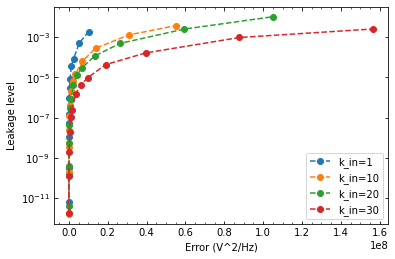

In [12]:
for i in range(len(kin)):
    each_k = (data[0]==kin[i])
    plt.semilogy(data[2][each_k], data[3][each_k],'o--',label='k_in={}'.format(kin[i]))
plt.legend()
# plt.xlim(0,10)
# plt.ylim(1e-12,1e-2)
plt.xlabel('Error (V^2/Hz)')
plt.ylabel('Leakage level')

In [18]:
data = np.loadtxt('/Users/zhaoyuhuai/Desktop/SeniorProj/Data/data_leakage_filterk_radiusvary_kin5.csv', unpack=True, usecols=(0,1,2,3))
radius = np.array([2,4,6,8,10,15,20])

Text(0, 0.5, 'Leakage level')

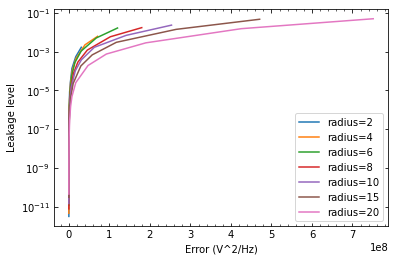

In [20]:
for i in range(len(radius)):
    each_k = (data[0]==radius[i])
    plt.semilogy(data[2][each_k], data[3][each_k],label='radius={}'.format(radius[i]))
plt.legend()
#plt.xlim(0,10)
#plt.ylim(1e-12,1e-2)
plt.xlabel('Error (V^2/Hz)')
plt.ylabel('Leakage level')